In [1]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import ydata_profiling
from ydata_profiling import ProfileReport

from scipy.signal import find_peaks, periodogram

import sys

In [2]:
# Print Python version
print("Python version:", sys.version)

# Print pandas version
print("pandas version:", pd.__version__)

# Print ydata_profiling version
print("ydata_profiling version:", ydata_profiling.__version__)

Python version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:12:24) [GCC 11.2.0]
pandas version: 2.2.2
ydata_profiling version: v4.9.0


In [3]:
# Set the maximum width of the display
pd.set_option('display.width', 1000)

# Set the maximum number of columns to display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 30)

pd.set_option('display.precision', 2)

In [4]:
# fetch dataset
data = fetch_ucirepo(id=374)
  
# variable information 
print(data.variables)

           name     role        type demographic description  units missing_values
0          date  Feature        Date        None        None   None             no
1    Appliances   Target     Integer        None        None     Wh             no
2        lights  Feature     Integer        None        None     Wh             no
3            T1  Feature  Continuous        None        None      C             no
4          RH_1  Feature  Continuous        None        None      %             no
5            T2  Feature  Continuous        None        None      C             no
6          RH_2  Feature  Continuous        None        None      %             no
7            T3  Feature  Continuous        None        None      C             no
8          RH_3  Feature  Continuous        None        None      %             no
9            T4  Feature  Continuous        None        None      C             no
10         RH_4  Feature  Continuous        None        None      %             no
11  

In [5]:
# Convert the data to a pandas DataFrame
df = pd.DataFrame(data=data.data.features)

re_express = r'(\d{4})-(\d{2})-(\d{2})(\d{2}):(\d{2}):(\d{2})'

# Replace using the pattern
df['date'] = df['date'].str.replace(re_express, r'\1-\2-\3 \4:\5:\6', regex=True)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S", errors='raise')

# df['date'] = pd.date_range(start='2016-01-11 17:00:00', end='2016-05-27 18:00:00', freq='10min')

# If the data has target labels, you can also add them to the DataFrame
df['target'] = data.data.targets

# # Set the 'date' column as the index
# df.set_index('date', inplace=True)

# # Optionally, sort the DataFrame by the new datetime index
# df.sort_index(inplace=True)

# Display the first few rows of the DataFrame
df.head()

,date,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,target
0,2016-01-11 17:00:00,30,19.89,47.60,19.2,44.79,19.79,44.73,19.00,45.57,17.17,55.20,7.03,84.26,17.20,41.63,18.2,48.90,17.03,45.53,6.60,733.5,92.0,7.00,63.00,5.3,13.28,13.28,60
1,2016-01-11 17:10:00,30,19.89,46.69,19.2,44.72,19.79,44.79,19.00,45.99,17.17,55.20,6.83,84.06,17.20,41.56,18.2,48.86,17.07,45.56,6.48,733.6,92.0,6.67,59.17,5.2,18.61,18.61,60
2,2016-01-11 17:20:00,30,19.89,46.30,19.2,44.63,19.79,44.93,18.93,45.89,17.17,55.09,6.56,83.16,17.20,41.43,18.2,48.73,17.00,45.50,6.37,733.7,92.0,6.33,55.33,5.1,28.64,28.64,50
3,2016-01-11 17:30:00,40,19.89,46.07,19.2,44.59,19.79,45.00,18.89,45.72,17.17,55.09,6.43,83.42,17.13,41.29,18.1,48.59,17.00,45.40,6.25,733.8,92.0,6.00,51.50,5.0,45.41,45.41,50
4,2016-01-11 17:40:00,40,19.89,46.33,19.2,44.53,19.79,45.00,18.89,45.53,17.20,55.09,6.37,84.89,17.20,41.23,18.1,48.59,17.00,45.40,6.13,733.9,92.0,5.67,47.67,4.9,10.08,10.08,60


In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,19735,2016-03-20 05:30:00,2016-01-11 17:00:00,2016-02-14 23:15:00,2016-03-20 05:30:00,2016-04-23 11:45:00,2016-05-27 18:00:00,NaN
lights,19735.0,3.8,0.0,0.0,0.0,0.0,70.0,7.94
T1,19735.0,21.69,16.79,20.76,21.6,22.6,26.26,1.61
RH_1,19735.0,40.26,27.02,37.33,39.66,43.07,63.36,3.98
T2,19735.0,20.34,16.1,18.79,20.0,21.5,29.86,2.19
RH_2,19735.0,40.42,20.46,37.9,40.5,43.26,56.03,4.07
T3,19735.0,22.27,17.2,20.79,22.1,23.29,29.24,2.01
RH_3,19735.0,39.24,28.77,36.9,38.53,41.76,50.16,3.25
T4,19735.0,20.86,15.1,19.53,20.67,22.1,26.2,2.04
RH_4,19735.0,39.03,27.66,35.53,38.4,42.16,51.09,4.34


In [7]:
from datetime import datetime

# Define your dates
date1 = datetime(2016, 1, 11)
date2 = datetime(2016, 5, 27)

# Calculate the difference
difference = date2 - date1

# Print the number of days
print(f"Number of days between {date1.date()} and {date2.date()}: {difference.days}")


Number of days between 2016-01-11 and 2016-05-27: 137


In [8]:
fs = pd.Timedelta("137D") / pd.Timedelta("10min")
print(fs) # fs needs to be equal the 9735.0, but this is not the case since there are some remaining minutes of the 27-5-2016.
fs = 19735.0

19728.0


In [9]:
df_time = df[['date', 'target']]

df_time.set_index('date', inplace = True)
df_time.sort_index()

df_time = df_time.to_period('10min')

# https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html
df_time.index = df_time.index.to_timestamp()

df_time.head()

,target
date,
2016-01-11 17:00:00,60
2016-01-11 17:10:00,60
2016-01-11 17:20:00,50
2016-01-11 17:30:00,50
2016-01-11 17:40:00,60


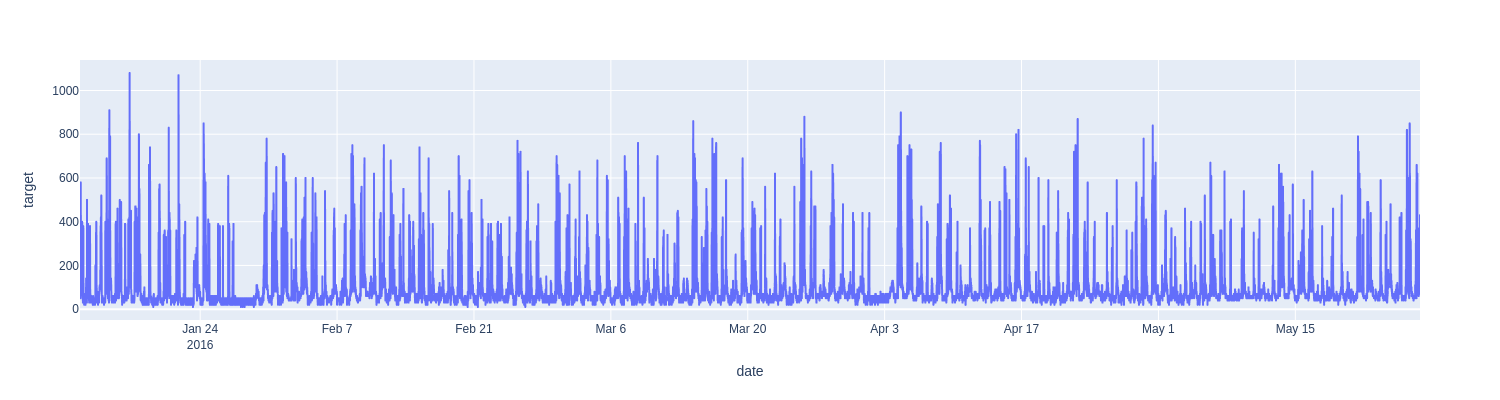

In [10]:
# Using plotly.express

fig = px.line(df_time, x=df_time.index, y='target')
fig.update_layout(width=1500, height=400)
# fig.show()
fig.show("png")

In [11]:
X = df_time.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.isocalendar().week   # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
X["hour"] = X.index.hour
X["quarter"] = X.index.quarter
X["month"] = X.index.month

In [12]:
X

,target,day,week,dayofyear,year,hour,quarter,month
date,,,,,,,,
2016-01-11 17:00:00,60,0,2,11,2016,17,1,1
2016-01-11 17:10:00,60,0,2,11,2016,17,1,1
2016-01-11 17:20:00,50,0,2,11,2016,17,1,1
2016-01-11 17:30:00,50,0,2,11,2016,17,1,1
2016-01-11 17:40:00,60,0,2,11,2016,17,1,1
2016-01-11 17:50:00,50,0,2,11,2016,17,1,1
2016-01-11 18:00:00,60,0,2,11,2016,18,1,1
2016-01-11 18:10:00,60,0,2,11,2016,18,1,1
2016-01-11 18:20:00,60,0,2,11,2016,18,1,1


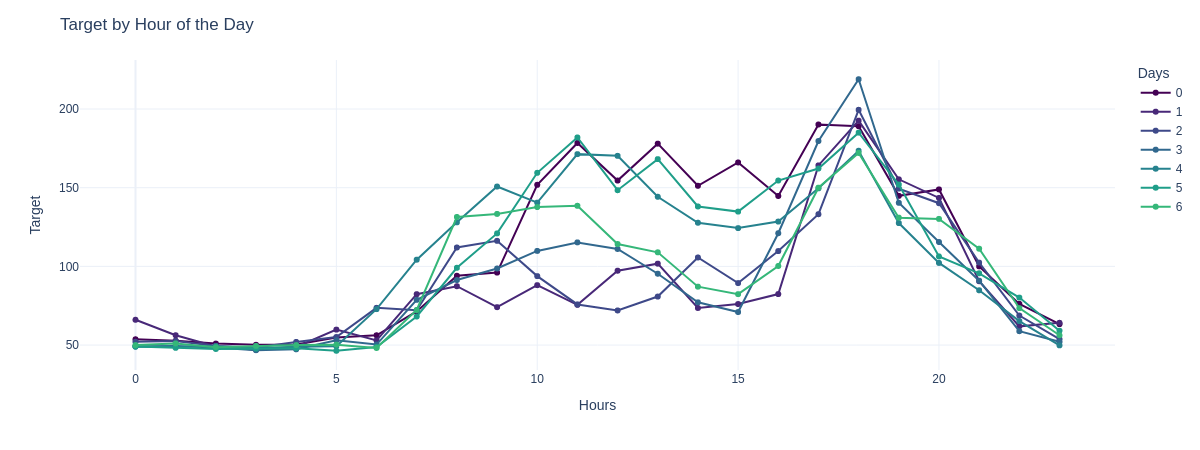

In [13]:
# 0 represents Monday
# 1 represents Tuesday
# 2 represents Wednesday
# 3 represents Thursday
# 4 represents Friday
# 5 represents Saturday
# 6 represents Sunday

# Create the line plot using Plotly
fig = px.line(
    X.groupby(['day', 'hour']).agg({'target': 'mean'}).reset_index(), 
    x='hour', 
    y='target', 
    color='day', 
    markers=True,
    color_discrete_sequence=px.colors.sequential.Viridis,  # Using a color palette similar to sns.color_palette("husl")
)

# Customize the layout
fig.update_layout(
    title="Target by Hour of the Day",
    xaxis_title="Hours",
    yaxis_title="Target",
    legend_title="Days",
    template="plotly_white",  # Set a clean white theme
    width=1200,  # Set the width of the plot
    height=450  # Set the height of the plot
)

# Show the plot
# fig.show()
fig.show("png")

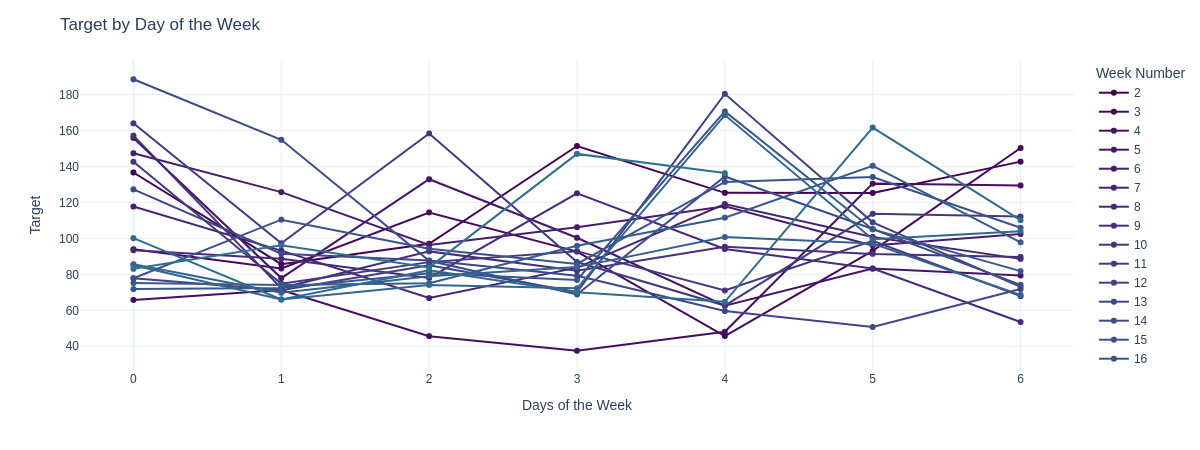

In [14]:
# Create the line plot using Plotly

colors = px.colors.sample_colorscale(px.colors.sequential.Viridis, np.linspace(0, 1, 53))

fig = px.line(
    X.groupby(['week', 'day']).agg({'target': 'mean'}).reset_index(),
    x='day',
    y='target',
    color='week',
    markers=True,
    color_discrete_sequence=colors,  # Using a color palette similar to sns.color_palette("husl")
)

# Customize the layout
fig.update_layout(
    title="Target by Day of the Week",
    xaxis_title="Days of the Week",
    yaxis_title="Target",
    legend_title="Week Number",
    template="plotly_white",  # Set a clean white theme
    width=1200,  # Set the width of the plot
    height=450  # Set the height of the plot
)

# Show the plot
# fig.show()
fig.show("png")


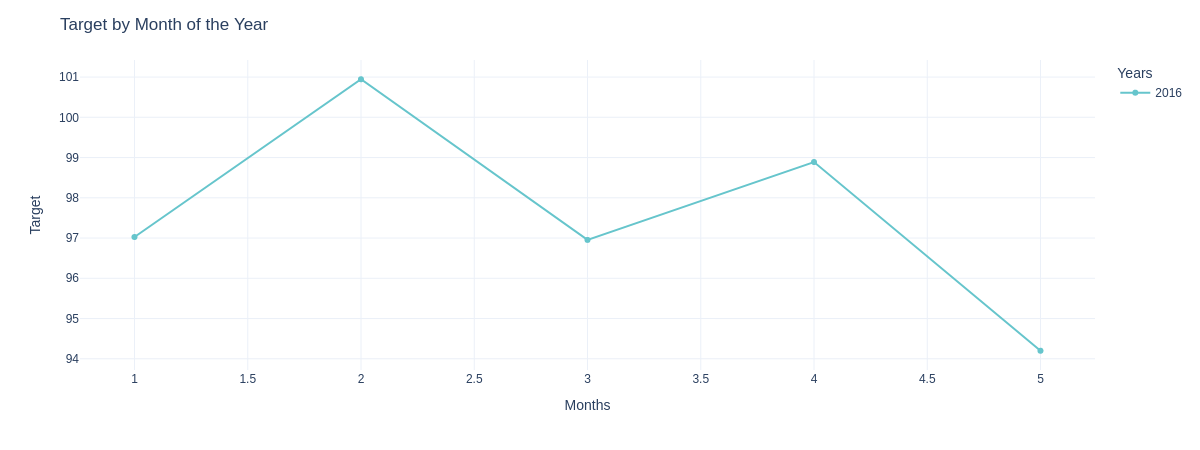

In [15]:
# Create the line plot using Plotly
fig = px.line(
    X.groupby(['year', 'month']).agg({'target': 'mean'}).reset_index(), 
    x='month', 
    y='target', 
    color='year', 
    markers=True,
    color_discrete_sequence=px.colors.qualitative.Pastel,  # Using a color palette similar to sns.color_palette("husl")
)

# Customize the layout
fig.update_layout(
    title="Target by Month of the Year",
    xaxis_title="Months",
    yaxis_title="Target",
    legend_title="Years",
    template="plotly_white",  # Set a clean white theme
    width=1200,  # Set the width of the plot
    height=450  # Set the height of the plot
)

# Show the plot
# fig.show()
fig.show("png")

In [16]:
frequencies, spectrum = periodogram(
    X.target,
    nfft=fs,
    detrend='linear',
    window="boxcar",
    scaling='density',
)

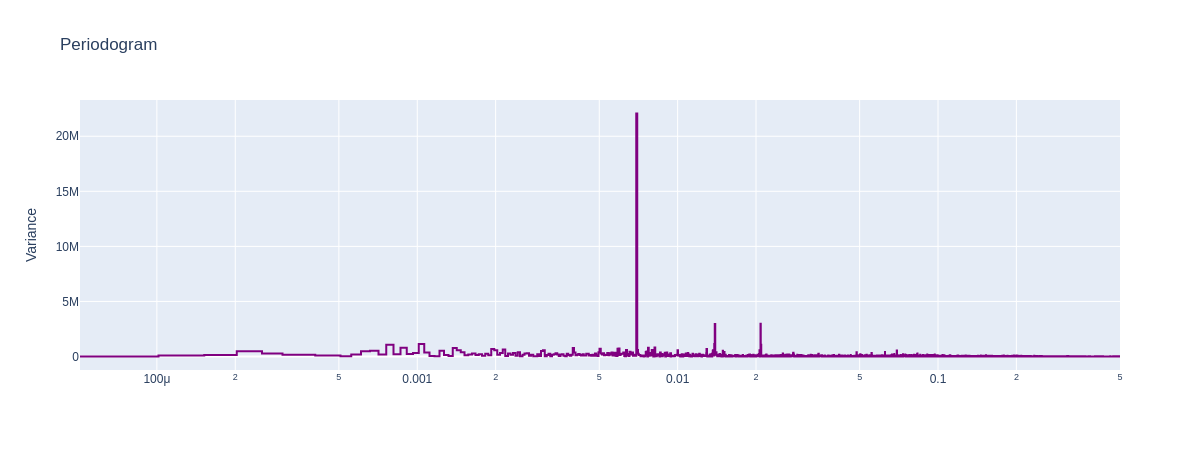

In [17]:

# Assuming 'frequencies' and 'spectrum' are defined and populated with data

fig = go.Figure()

# Add step plot
fig.add_trace(go.Scatter(
    x=frequencies,
    y=spectrum,
    mode='lines',
    line=dict(shape='hv', color='purple')
))

# Set x-axis to logarithmic scale
fig.update_xaxes(type="log")

# Add labels and title
fig.update_layout(
    yaxis_title="Variance",
    title="Periodogram",
    width=1200,  # Set the width of the plot
    height=450  # Set the height of the plot
)

# Show plot
# fig.show()
fig.show("png")

In [18]:
# x = np.array([4, 3, 1, 2, 5])
# po = np.argsort(x) # po: [2 3 1 0 4]
# x[po] # array([1, 2, 3, 4, 5])

peaks_indices, _ = find_peaks(spectrum)
for i in range(1, 6):
    top_peaks_indices = np.argsort(spectrum[peaks_indices])[-i] # the last element
    top_frequencies = frequencies[peaks_indices][top_peaks_indices]
    top_spectrum = spectrum[peaks_indices][top_peaks_indices]
    if i == 1: 
        top_spec = top_spectrum 
    print(f'{i}º higher frequency: {1/top_frequencies} - {top_spectrum / top_spec * 100}') 

1º higher frequency: 144.05109489051097 - 100.0
2º higher frequency: 48.01703163017032 - 13.515369073097027
3º higher frequency: 72.02554744525548 - 13.343137164947727
4º higher frequency: 986.7500000000001 - 5.184203625094041
5º higher frequency: 1315.6666666666667 - 4.850136840147577


In [19]:
# 24 hours * 60 minuts = 1440 => 1 day
# 1440 min / 10 min = 144 => 1 day


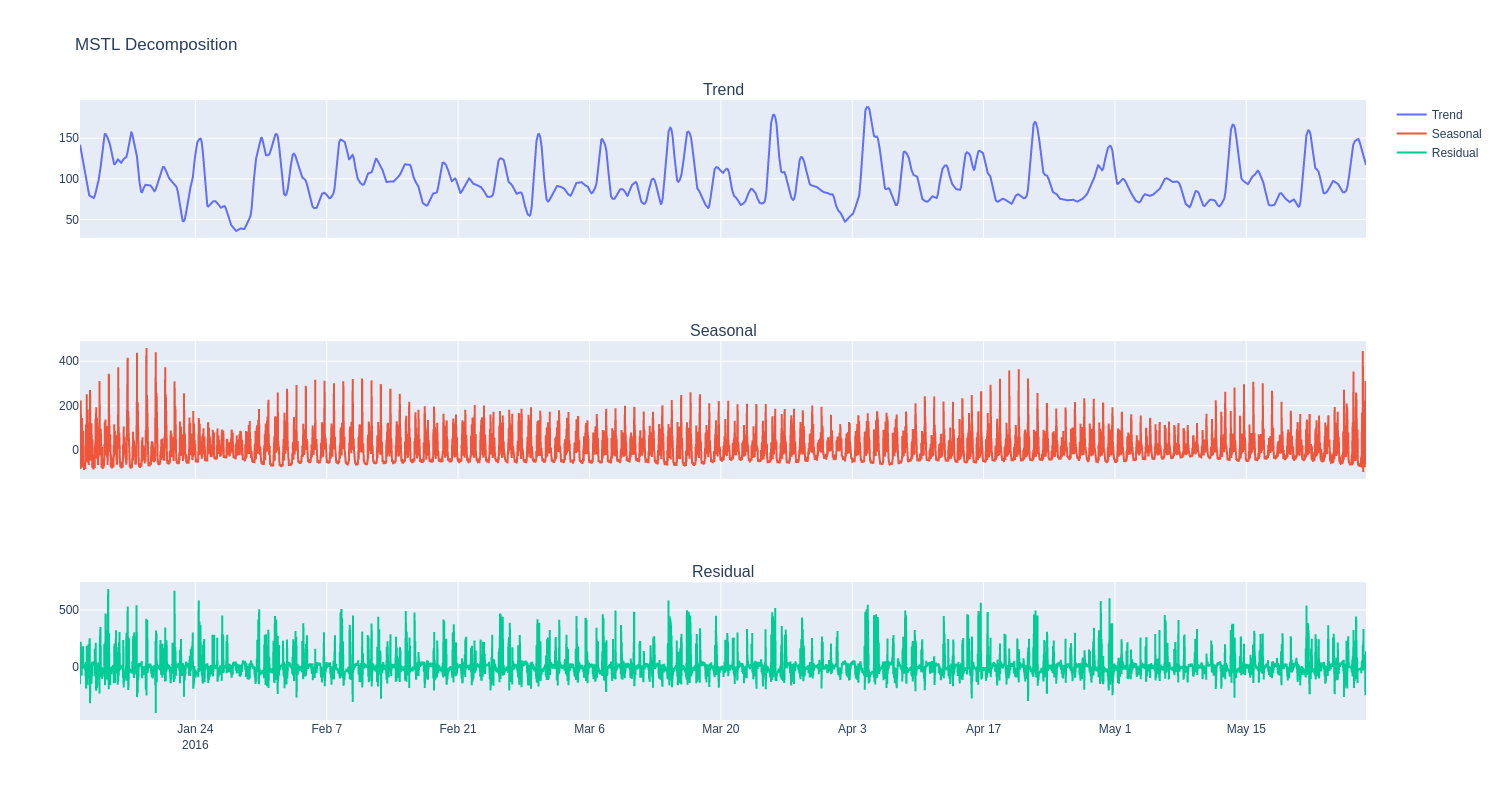

In [20]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import MSTL

# Assuming X.target is your time series data
mstl = MSTL(X.target, periods=[144]).fit()

# Extract components
trend = mstl.trend
seasonal = mstl.seasonal
residual = mstl.resid

# Create a Plotly subplot figure
fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
                    subplot_titles=("Trend", "Seasonal", "Residual"))

# Add traces for each component
fig.add_trace(go.Scatter(x=trend.index, y=trend, mode='lines', name='Trend'), row=1, col=1)
fig.add_trace(go.Scatter(x=seasonal.index, y=seasonal, mode='lines', name='Seasonal'), row=2, col=1)
fig.add_trace(go.Scatter(x=residual.index, y=residual, mode='lines', name='Residual'), row=3, col=1)

# Update layout
fig.update_layout(height=800, width=1500, title_text="MSTL Decomposition")

# Show the figure
# fig.show()
fig.show("png")
